In [1]:
!pip install transformers datasets evaluate accelerate trl bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
import torch.nn as nn
from timm.layers import LayerNorm2d


class DynamicTanh(nn.Module):
    def __init__(self, normalized_shape, channels_last, alpha_init_value=0.5):
        super().__init__()
        self.normalized_shape = normalized_shape
        self.alpha_init_value = alpha_init_value
        self.channels_last = channels_last

        self.alpha = nn.Parameter(torch.ones(1) * alpha_init_value)
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))

    def forward(self, x):
        x = torch.tanh(self.alpha * x)
        if self.channels_last:
            x = x * self.weight + self.bias
        else:
            x = x * self.weight[:, None, None] + self.bias[:, None, None]
        return x

    def extra_repr(self):
        return f"normalized_shape={self.normalized_shape}, alpha_init_value={self.alpha_init_value}, channels_last={self.channels_last}"


def convert_ln_to_dyt(module, name=''):
    module_output = module
    if isinstance(module, nn.LayerNorm):
      #paper mentions alhpa dependent on width for LLMs : for 1024 is 1.0 for attention DyT, 0.1 for other
        if name == 'post_attention_layernorm':
            module_output = DynamicTanh(module.normalized_shape, not isinstance(module, LayerNorm2d), alpha_init_value=1.0)
        if name == 'input_layernorm' or name == 'final_layer_norm':
            module_output = DynamicTanh(module.normalized_shape, not isinstance(module, LayerNorm2d), alpha_init_value=1.0)
    for name, child in module.named_children():
        module_output.add_module(name, convert_ln_to_dyt(child, name))
    del module
    return module_output

In [3]:
from huggingface_hub import login
login()

Tokenizer

In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM
tokenizer = AutoTokenizer.from_pretrained("chardizard/DyTPythia410mRE-WILD", padding_side='left')
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/4.87k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

DyT

In [5]:
model = AutoModelForCausalLM.from_pretrained("chardizard/DyTPythia410mRE-WILD", cache_dir = "/content")

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

Some weights of the model checkpoint at chardizard/DyTPythia410mRE-WILD were not used when initializing GPTNeoXForCausalLM: ['gpt_neox.final_layer_norm.alpha', 'gpt_neox.layers.0.input_layernorm.alpha', 'gpt_neox.layers.0.post_attention_layernorm.alpha', 'gpt_neox.layers.1.input_layernorm.alpha', 'gpt_neox.layers.1.post_attention_layernorm.alpha', 'gpt_neox.layers.10.input_layernorm.alpha', 'gpt_neox.layers.10.post_attention_layernorm.alpha', 'gpt_neox.layers.11.input_layernorm.alpha', 'gpt_neox.layers.11.post_attention_layernorm.alpha', 'gpt_neox.layers.12.input_layernorm.alpha', 'gpt_neox.layers.12.post_attention_layernorm.alpha', 'gpt_neox.layers.13.input_layernorm.alpha', 'gpt_neox.layers.13.post_attention_layernorm.alpha', 'gpt_neox.layers.14.input_layernorm.alpha', 'gpt_neox.layers.14.post_attention_layernorm.alpha', 'gpt_neox.layers.15.input_layernorm.alpha', 'gpt_neox.layers.15.post_attention_layernorm.alpha', 'gpt_neox.layers.16.input_layernorm.alpha', 'gpt_neox.layers.16.post

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [6]:
from safetensors.torch import load_model, save_model
weightdir = "/content/models--chardizard--DyTPythia410mRE-WILD/snapshots/dbbcfd420e0a75384353f39990b071e3767a8088/model.safetensors"
model = convert_ln_to_dyt(model).to("cuda")
load_model(model, weightdir)
model.config.pad_token_id = tokenizer.pad_token_id

Vanilla

In [5]:
model = AutoModelForCausalLM.from_pretrained("chardizard/Pythia410mRE-WILD", revision= "f16922a").to("cuda")
model.config.pad_token_id = tokenizer.pad_token_id

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

MT bench dataset

In [7]:
from datasets import load_dataset

ds = load_dataset("HuggingFaceH4/mt_bench_prompts")['train']
ds = ds.remove_columns(['category', 'reference', 'prompt_id'])

README.md:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


(…)-00000-of-00001-67c6c9fef07685a3.parquet:   0%|          | 0.00/30.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/80 [00:00<?, ? examples/s]

In [8]:
inputs = tokenizer(ds['prompt'], return_tensors="pt", padding=True).to("cuda")

In [9]:
import time
start = time.time()
generated_ids = model.generate(**inputs, max_new_tokens=1024).to("cpu")
end = time.time()

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


In [9]:
print("Vanilla inference speed: " + str(end-start) + " seconds")

Vanilla inference speed: 77.46317315101624 seconds


In [10]:
print("DyT inference speed: " + str(end-start) + " seconds")

DyT inference speed: 77.0466194152832 seconds


In [10]:
outputs = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

In [11]:
outputs

['Compose an engaging travel blog post about a recent trip to Hawaii, highlighting cultural experiences and must-see attractions.Rewrite your previous response. Start every sentence with the letter A.',
 'Draft a professional email seeking your supervisor\'s feedback on the \'Quarterly Financial Report\' you prepared. Ask specifically about the data analysis, presentation style, and the clarity of conclusions drawn. Keep the email short and to the point.Take a moment to evaluate and critique your own response.Subject: Request for Feedback on Quarterly Financial Report\n\nDear [Supervisor\'s Name],\n\nI hope this message finds you well.\n\nI am writing to request your feedback on the Quarterly Financial Report. I have reviewed the data analysis, presentation style, and the clarity of conclusions drawn. I am particularly interested in the data analysis and the presentation style, as well as the clarity of conclusions.\n\n**1. Data Analysis:**\n- **Summary:** The data analysis revealed th

In [21]:
inputs

{'input_ids': tensor([[    0,     0,     0,  ...,  4857,   329,    15],
        [    0,     0,     0,  ...,  1211,  2380,    15],
        [    0,     0,     0,  ...,   254,   781,    15],
        ...,
        [    0,     0,     0,  ...,   323,  4730,    15],
        [    0,     0,     0,  ...,  5464, 22429,    15],
        [    0,     0,     0,  ..., 18539,   414,    15]], device='cuda:0'), 'attention_mask': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]], device='cuda:0')}

In [12]:
prompt_length = inputs['input_ids'].shape[1]

answers = []
for generated_id in generated_ids:
    answers.append(tokenizer.decode(generated_id[prompt_length:], skip_special_tokens=True))

In [16]:
answers[2]

'### Title: "Comparing the Two Smartphones: A Comparative Analysis"\n\n### Introduction\n\nIn the realm of smartphone technology, the two most popular models are the **Smartphone** and **Phone** models. These models are designed to enhance the user experience by providing a seamless and intuitive experience. However, they have their own unique characteristics that make them stand out in the market. Let\'s break down the key features and performance features of the two models:\n\n### Smartphone\n\n1. **Smartphone Features:**\n   - **High-Quality Graphics:** The smartphone features a high-resolution image of the user\'s face, which is crucial for visualizing and engaging with the user.\n   - **Multiple Camera:** The smartphone has a variety of cameras, including the smartphone\'s camera, camera, and other smartphone devices.\n   - **Multiple Inputs:** The smartphone has multiple input devices, including the smartphone\'s keyboard, keyboard, and other smartphone devices.\n   - **Multiple 

In [17]:
ds = ds.add_column("answer", answers)

In [45]:
ds[66]

{'prompt': ['The city of Vega intends to build a bridge that will span the Vegona River, covering a distance of 1.8 kilometers. The proposed location falls within a seismically active area that has experienced several high-magnitude earthquakes. Given these circumstances, what would be the best approach to constructing the bridge?',
  'What are the key disadvantages or flaws of your solution? Please perform calculations and use numbers to illustrate them.'],
 'answer': "To construct a bridge spanning the Vegona River in a seismically active area, the city of Vega's proposed location falls within a region that has experienced several high-magnitude earthquakes. Given these conditions, the best approach would be to use a combination of geological engineering, geophysics, and engineering simulations.\n\n### Geological Engineering Considerations\n\n1. **Seismic Activity**:\n   - The area is likely to have a high-magnitude earthquake activity, which can cause significant structural damage a

In [18]:
ds[66]

{'prompt': ['The city of Vega intends to build a bridge that will span the Vegona River, covering a distance of 1.8 kilometers. The proposed location falls within a seismically active area that has experienced several high-magnitude earthquakes. Given these circumstances, what would be the best approach to constructing the bridge?',
  'What are the key disadvantages or flaws of your solution? Please perform calculations and use numbers to illustrate them.'],
 'answer': 'Certainly! The proposed location of the city of Vega is a complex and multifaceted area, encompassing a wide range of natural and human-like phenomena. Here’s a detailed breakdown of the key advantages and disadvantages of the proposed location:\n\n### 1. **High-Magnitude Seismatic Events**\n- **High-Magnitude Seismatic Events**: These are the most likely and most likely events that would occur in the area. These are the most likely and likely to occur in the area.\n- **High-Magnitude Seismatic Events**: These are the m

In [19]:
login()

In [46]:
ds

Dataset({
    features: ['prompt', 'answer'],
    num_rows: 80
})

In [47]:
ds.push_to_hub("chardizard/mt_bench_answers_vanilla")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/308 [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/chardizard/mt_bench_answers_vanilla/commit/253aa79e2e9824c60596c0e9c3e52c642cea33bc', commit_message='Upload dataset', commit_description='', oid='253aa79e2e9824c60596c0e9c3e52c642cea33bc', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/chardizard/mt_bench_answers_vanilla', endpoint='https://huggingface.co', repo_type='dataset', repo_id='chardizard/mt_bench_answers_vanilla'), pr_revision=None, pr_num=None)

In [20]:
ds.push_to_hub("chardizard/mt_bench_answers_dyt")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/chardizard/mt_bench_answers_dyt/commit/ea526b9b4704c9fc804857a0ed8c22e65be7cd9f', commit_message='Upload dataset', commit_description='', oid='ea526b9b4704c9fc804857a0ed8c22e65be7cd9f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/chardizard/mt_bench_answers_dyt', endpoint='https://huggingface.co', repo_type='dataset', repo_id='chardizard/mt_bench_answers_dyt'), pr_revision=None, pr_num=None)

Judging

In [5]:
from datasets import load_dataset
vanilla = load_dataset("chardizard/mt_bench_answers_vanilla")['train']
dyt = load_dataset("chardizard/mt_bench_answers_dyt")['train']

README.md:   0%|          | 0.00/308 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/97.0k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/80 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/308 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/70.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/80 [00:00<?, ? examples/s]

In [6]:
prompts = []
for i in range(len(vanilla)):
  prompts.append(vanilla[i]['prompt'][0])

In [30]:
prompts

['Compose an engaging travel blog post about a recent trip to Hawaii, highlighting cultural experiences and must-see attractions.',
 "Draft a professional email seeking your supervisor's feedback on the 'Quarterly Financial Report' you prepared. Ask specifically about the data analysis, presentation style, and the clarity of conclusions drawn. Keep the email short and to the point.",
 'Imagine you are writing a blog post comparing two popular smartphone models. Develop an outline for the blog post, including key points and subheadings to effectively compare and contrast the features, performance, and user experience of the two models. Please answer in fewer than 200 words.',
 'Write a persuasive email to convince your introverted friend, who dislikes public speaking, to volunteer as a guest speaker at a local event. Use compelling arguments and address potential objections. Please be concise.',
 'Describe a vivid and unique character, using strong imagery and creative language. Please 

In [7]:
completions = []
for i in range(len(vanilla)):
  completions.append([vanilla[i]['answer'], dyt[i]['answer']])

In [34]:
completions[0]

['Sure, here’s a engaging travel blog post about a recent trip to Hawaii, highlighting cultural experiences and must-see attractions:\n\n---\n\n**A Splash of Color in Hawaii: A Journey Through Time**\n\nOn a chilly, sunny day in Hawaii, I had the incredible opportunity to immerse myself in a culture unlike any other. From the lush landscapes of the Hawaiian Islands to the vibrant culture of the Pacific, this trip was a journey through time, a testament to the power of travel and the beauty of the natural world.\n\n**The Land of the Blue Sea**\n\nThe first stop was the iconic Blue Sea, a breathtaking sight that cuts through the calm waters of the Hawaiian Islands. The blue sky and the gentle waves were a perfect backdrop to the serene atmosphere. The island’s unique architecture, including the iconic Blue Lagoon, was a testament to the island’s rich history and natural beauty.\n\n**The Great Barrier Reef**\n\nNext, we explored the Great Barrier Reef, a UNESCO World Heritage site that sp

In [8]:
!pip install trl[judges]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.7 MB/s eta 0:00:00


In [9]:
!pip install llm-blender

In [10]:
from trl import PairRMJudge
import llm_blender

judge = PairRMJudge()
scores = judge.judge(
    prompts=prompts,
    completions=completions,
)  # Outputs: [0, 1]

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/13.7k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/130 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

ranker_config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.79k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/dataclasses_json/core.py:201: RuntimeWarning: 'NoneType' object value of non-optional type load_checkpoint detected when decoding RankerConfig.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/dataclasses_json/core.py:201: RuntimeWarning: 'NoneType' object value of non-optional type device detected when decoding RankerConfig.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/874M [00:00<?, ?B/s]

Successfully loaded ranker from  /root/.cache/huggingface/hub/llm-blender/PairRM


In [11]:
scores

[1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0]

In [12]:
vanillascores = 0
dytscores = 0
for score in scores:
  if score == 0:
    vanillascores += 1
  else:
    dytscores += 1

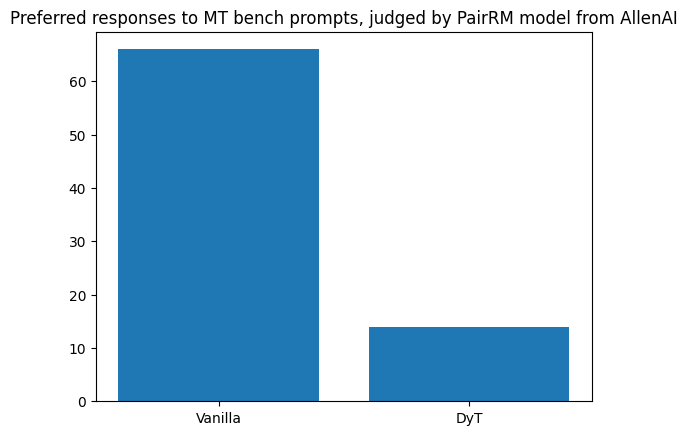

In [14]:
from matplotlib import pyplot as plt
plt.bar(['Vanilla', 'DyT'], [vanillascores, dytscores])
plt.title('Preferred responses to MT bench prompts, judged by PairRM model from AllenAI')
plt.show()